# Recommender ChatBot: Update Users and Items embeddings using DeepFM model

Generate users/items embeddings using DeepFM collaborative filtering model Then store embeddings into a chromadb database.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH    = '../..'
LIB_PATH     = f'{BASE_PATH}/lib'
API_PATH     = f'{BASE_PATH}/chat-bot-api'

In [3]:
import sys
sys.path.append(LIB_PATH)
sys.path.append(API_PATH)


import torch
import pytorch_common
import pytorch_common.util as pu
import util as ut
import os

import rest
import pandas as pd

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
import pytorch_common
pytorch_common.__version__

'0.3.8'

In [6]:
torch.__version__

'2.1.2+cu118'

In [7]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
ut.set_seed(42)

In [9]:
os.environ['TMP_PATH']         = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']     = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']     = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']     = f'{BASE_PATH}/metrics'
os.environ['MONGODB_URL']      = 'mongodb://0.0.0.0:27017'
os.environ['MONGODB_DATABASE'] = 'chatbot'
os.environ['CHROMA_HOST']      = '0.0.0.0'
os.environ['CHROMA_PORT']      = '9090'


from app_context import AppContext

2024-02-07 19:51:33.554687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 19:51:34.047821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-07 19:51:34.318914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 19:51:34.330128: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

<Figure size 640x480 with 0 Axes>

## Run Job

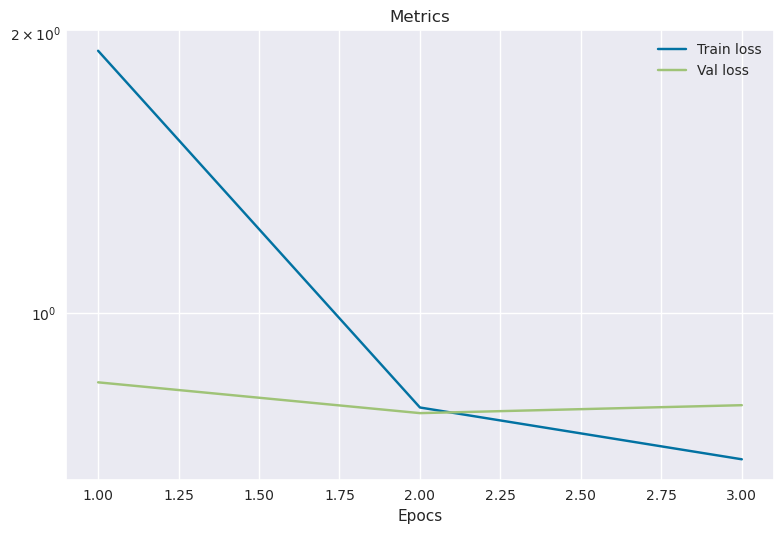

2024-02-07 19:52:25,618 - INFO - {'time': '0:00:08.82', 'epoch': 4, 'train_loss': 0.6350177408648091, 'val_loss': 0.7890396118164062, 'lr': 0.001}


Processing:   0%|          | 0/250 [00:00<?, ?it/s]

Ordered by mAP@5(4,5):


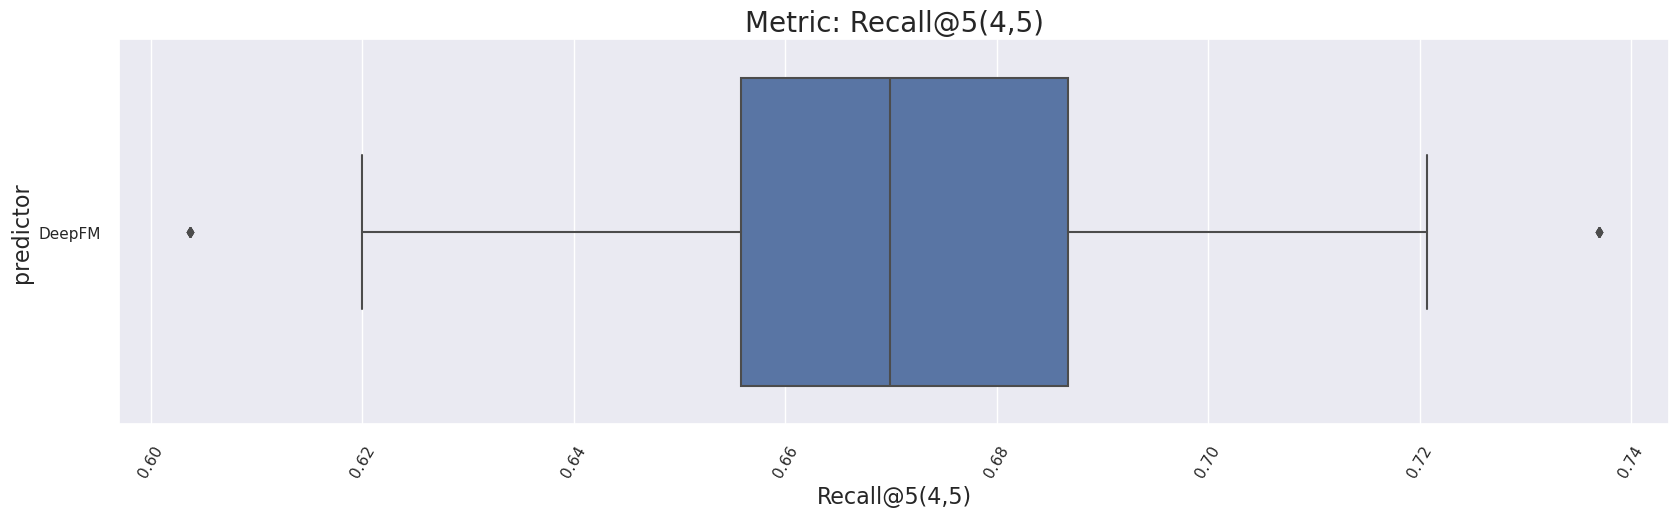

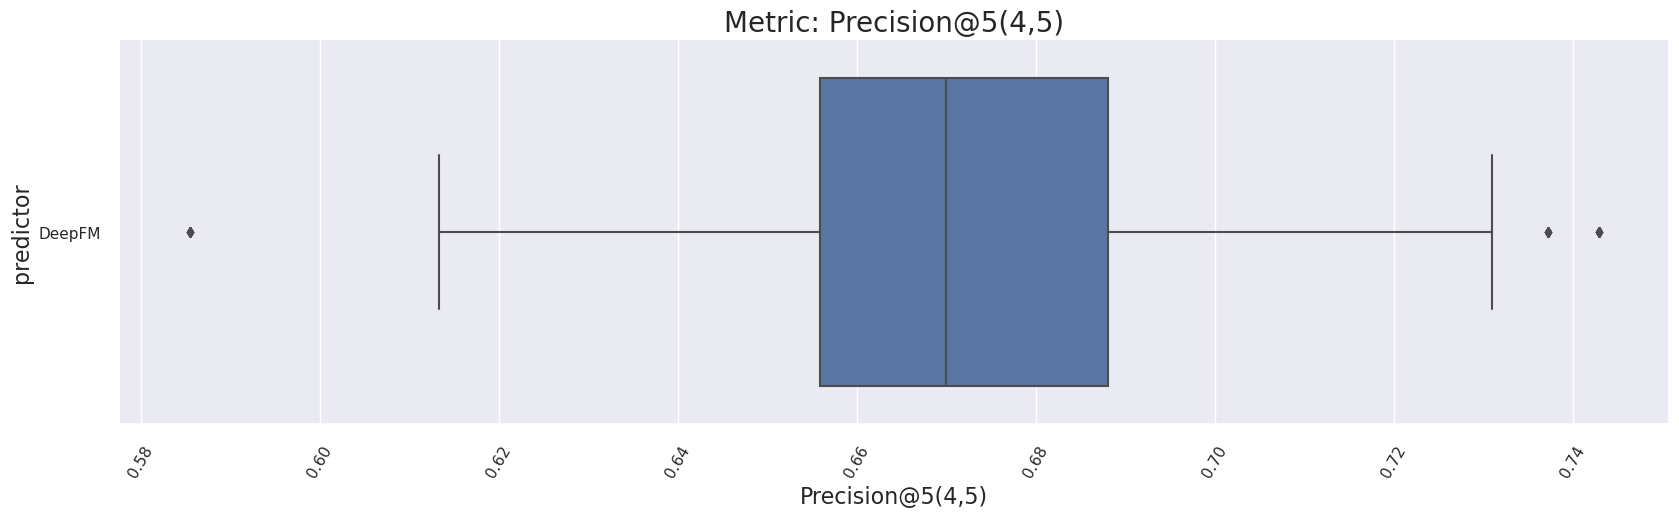

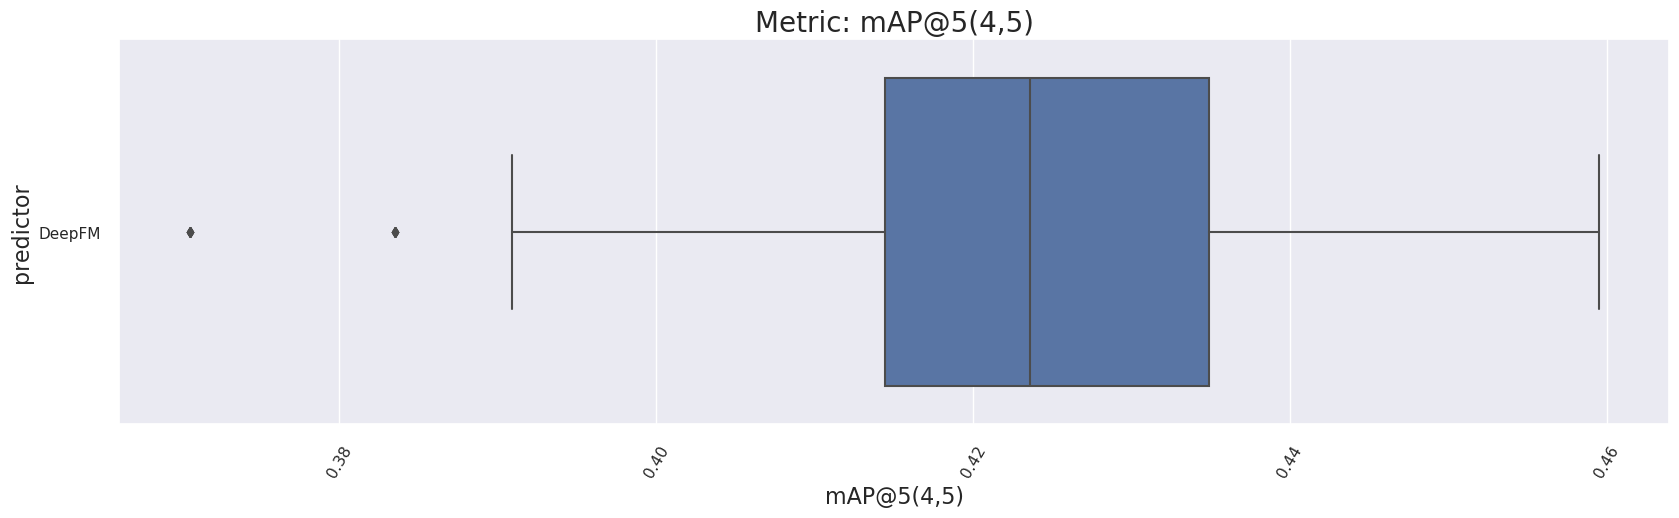

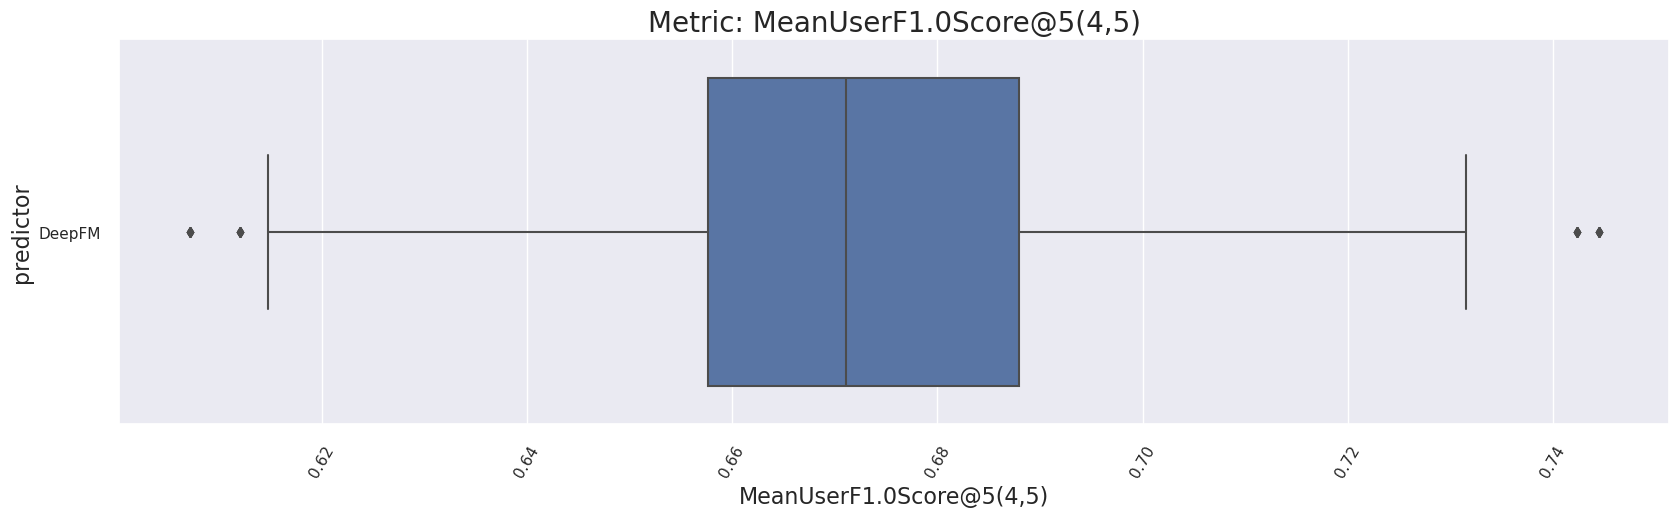

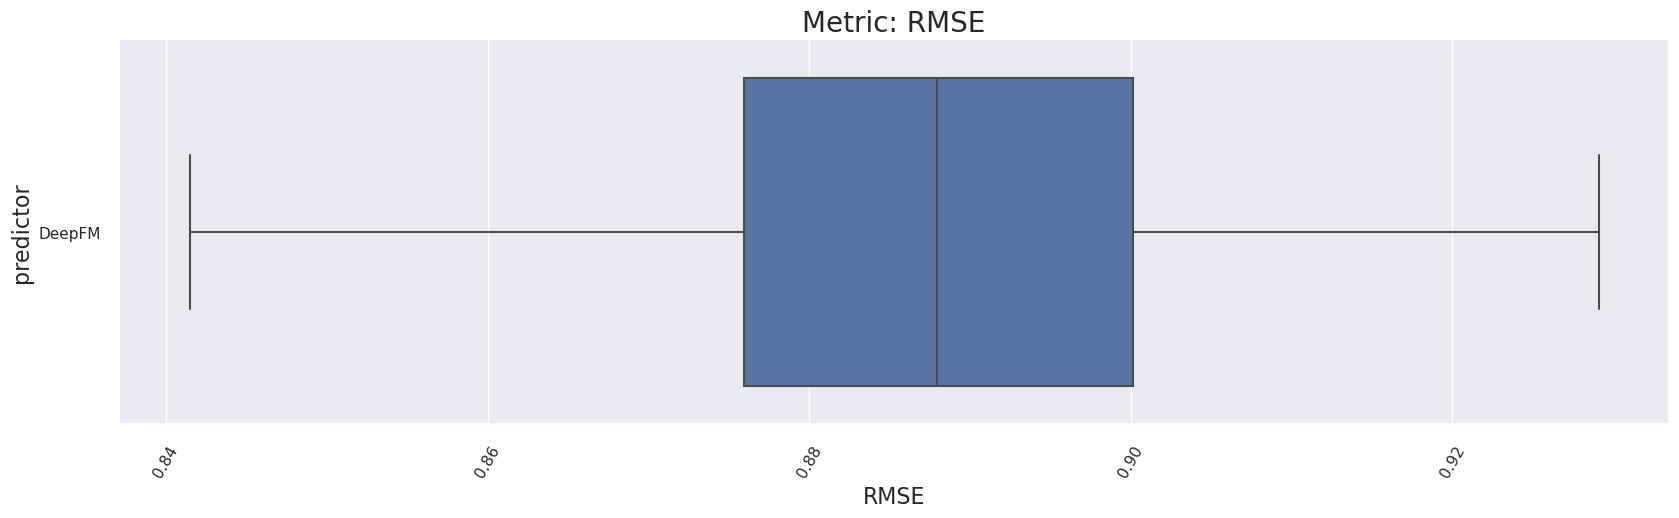

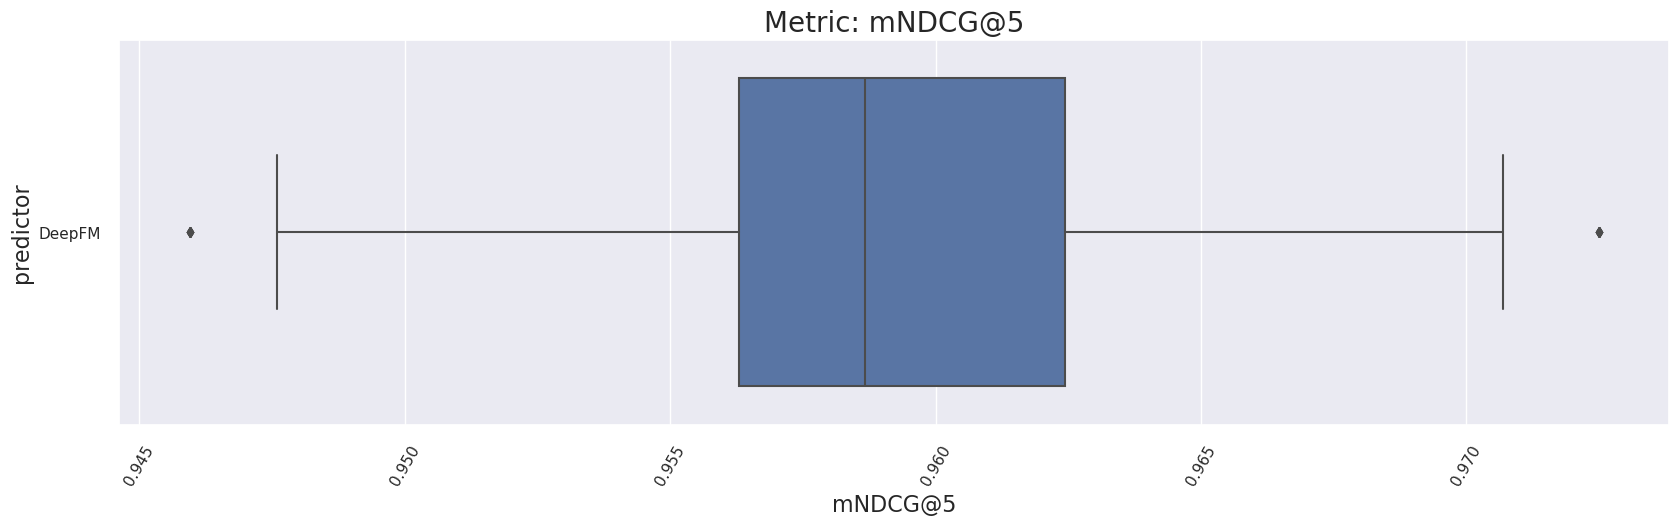

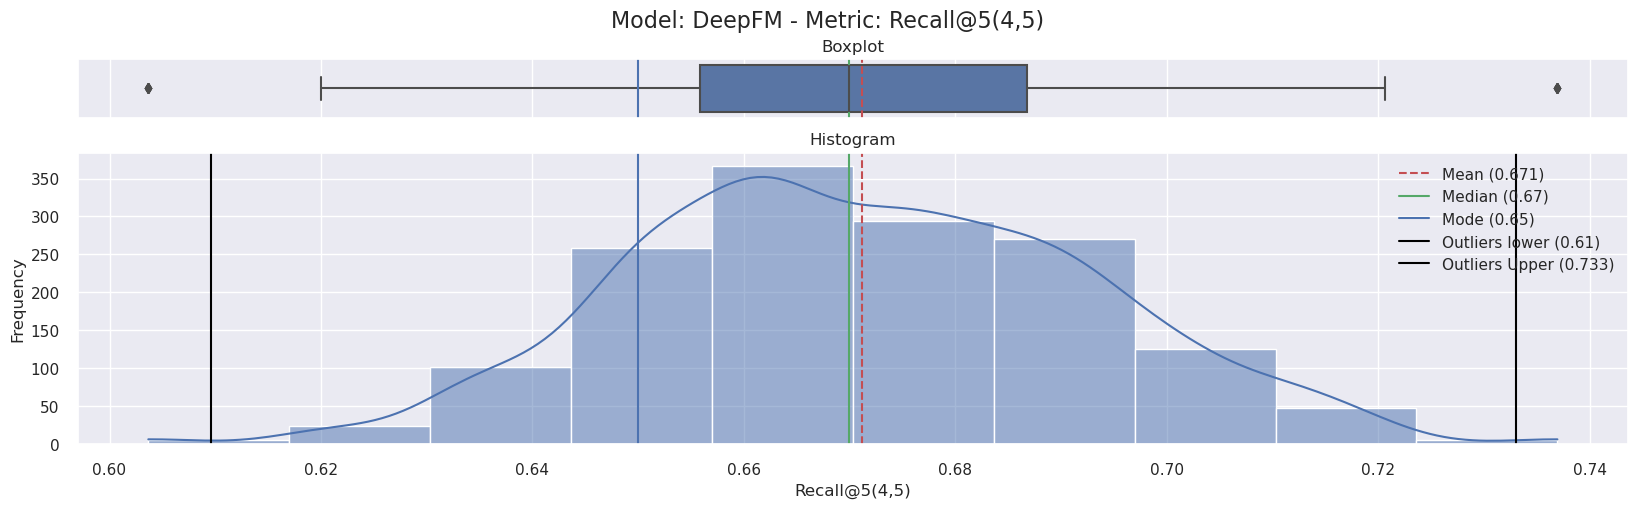

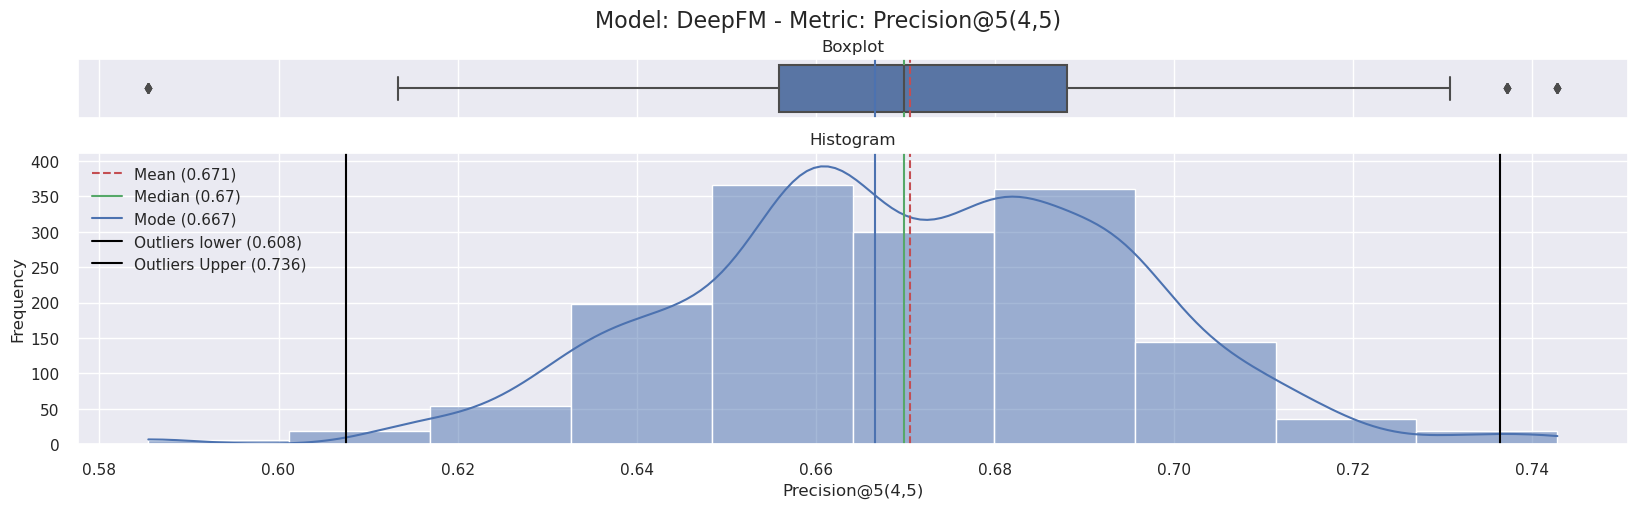

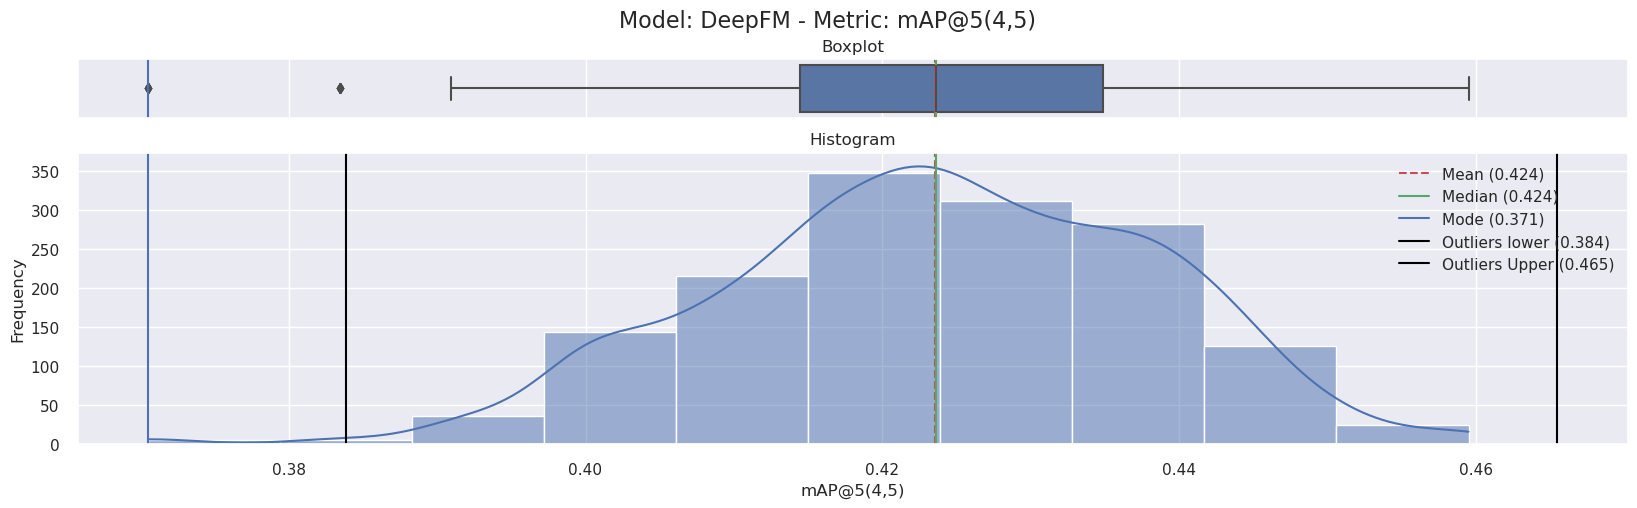

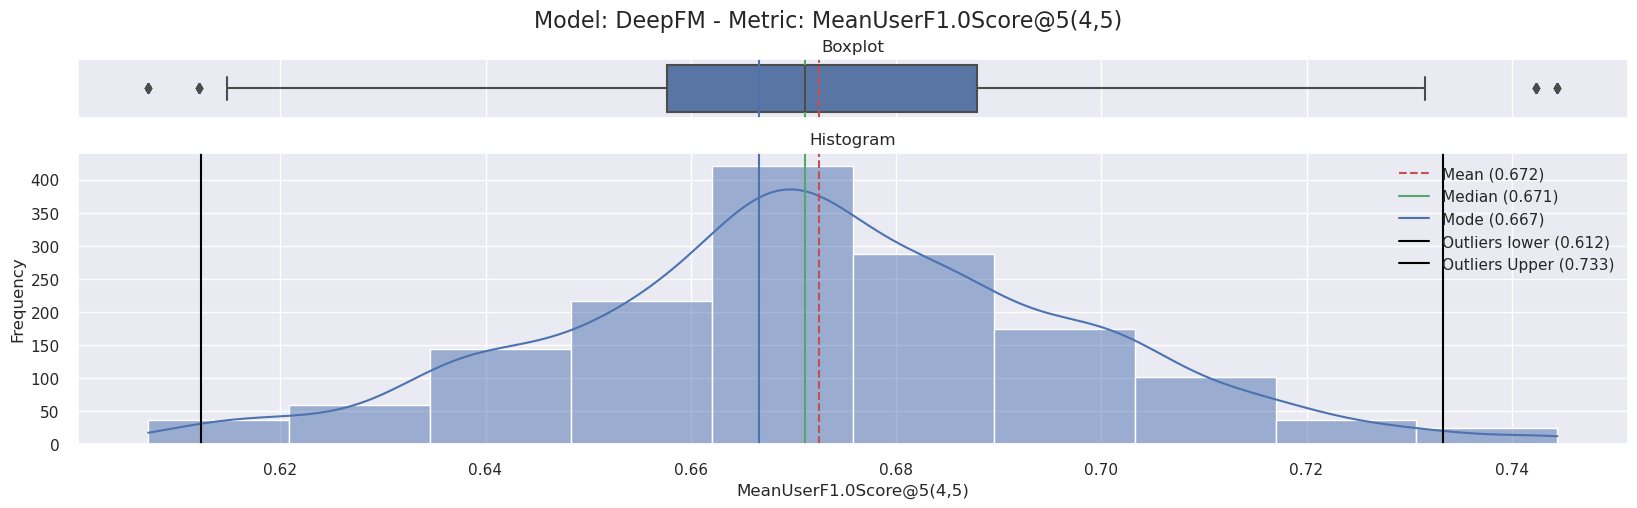

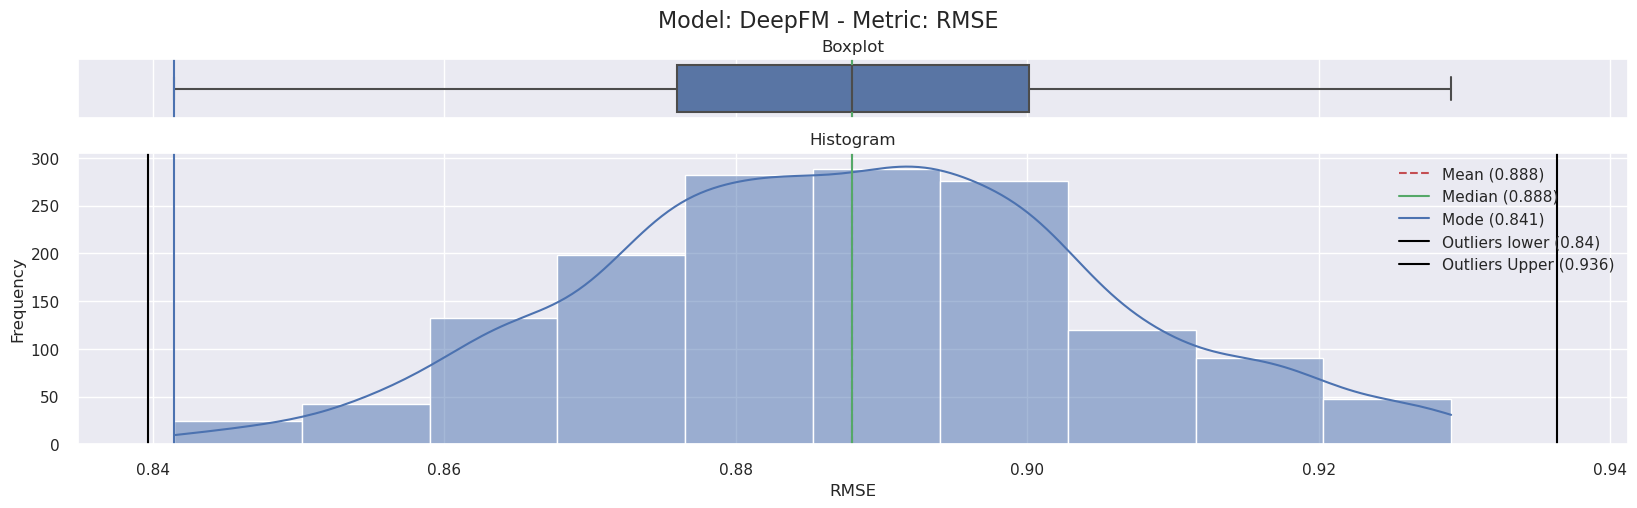

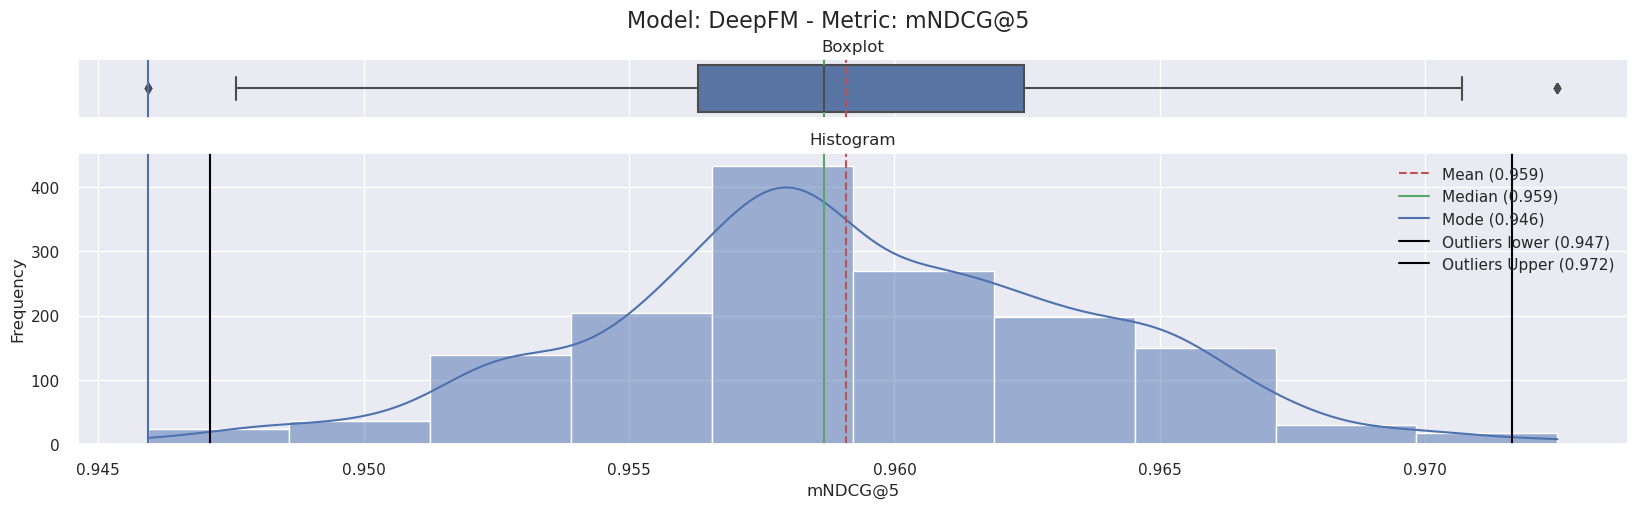

2024-02-07 19:53:01,825 - INFO - Get feature 0 embeddings [12763, 50]. Detail: Embeddings from 0 to 12762 from weights [27791, 50]
2024-02-07 19:53:01,825 - INFO - Get feature 1 embeddings [15028, 50]. Detail: Embeddings from 12763 to 27790 from weights [27791, 50]


Insert Embeddings:   0%|          | 0/12763 [00:00<?, ?it/s]

Insert Embeddings:   0%|          | 0/15028 [00:00<?, ?it/s]

In [10]:
user_embs, item_embs = AppContext().cf_emb_update_job()

## Simple item embeddings evaluation

In [46]:
def to_df(items, distances):
    items_df = pd.DataFrame.from_records([i.dict(exclude_none=True) for i in items])
    items_df['distance'] = distances
    return items_df.loc[:, ~items_df.columns.isin(['embedding'])]

In [47]:
ctx = AppContext()

items, distances = await ctx.item_service.find_by_content('Toy Story')
to_df(items, distances)

2024-02-07 20:27:33,573 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2
2024-02-07 20:27:34,045 - INFO - Use pytorch device: cuda
2024-02-07 20:27:34,046 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-02-07 20:27:34,047 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


,id,title,description,release,genres,rating,poster,distance
0,1,Toy Story,"Led by Woody, Andy's toys live happily in his ...",1995,"[adventure, animation, children, comedy, fantasy]",3.806931,http://image.tmdb.org/t/p/w500/uXDfjJbdP4ijW5h...,0.638016
1,106022,Toy Story of Terror,What starts out as a fun road trip for the Toy...,2013,"[animation, children, comedy]",4.000000,http://image.tmdb.org/t/p/w500/oPBEnNP4Fg4gv9c...,0.737461
2,120474,Toy Story That Time Forgot,"During a post-Christmas play date, the gang fi...",2014,"[animation, children]",3.666667,http://image.tmdb.org/t/p/w500/pw1YgzcBw4Gmwyl...,0.743833
3,3114,Toy Story 2,"Andy heads off to Cowboy Camp, leaving his toy...",1999,"[adventure, animation, children, comedy, fantasy]",3.670213,http://image.tmdb.org/t/p/w500/2MFIhZAW0CVlEQr...,0.774298
4,78499,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...",2010,"[adventure, animation, children, comedy, fanta...",4.000000,http://image.tmdb.org/t/p/w500/AbbXspMOwdvwWZg...,0.785197
